In [1]:
# Dataframe manipulations
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Modules needed to perform necessary functions
import wrangle_zillow as w
import explore as e
import modeling as m

# Turning off warnings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

## Overview:
The purpose of this project is to assist in the prediction of log error for Zillow's Zestimate house value predictions. This will be done by:
- Identifying some of the key drivers behind the log error
- Applying these insights to regression models that can help predict the log error
- Sharing learned insights to provide recommendations and solutions moving forward 

### Planning:
Prior to interacting with the data we want to lay out some of our intentions/initial questions:

Some of the initial questions for the data: 
1. Do primary house attributes impact log error? (bedrooms, bathrooms, age, squarefeet)
2. Do secondary house attributes impact log error? (num_fireplace, threequarter_baths, hottub_or_spa, has_pool)
3. Does geography impact log error? (latitude, longitude, regionidzip, fips)
4. Can we successfully use any of our features to cluster for log error predictions?
    - Geographic clustering
        - Latitude/Longitude
    - Continuous feature clustering
5. What can we identify about the data when log error is postive or negative?

Some of the hypotheses to be explored:
1. Is there a linear relationship between log error and our continuous features? (Pearsonr)
2. Is there a difference in the mean log error for selected subsets and the entire dataset? (one-sample t-test)
3. Is there a difference in the mean log error of particular zip codes and the entire dataset? (one-sample t-test)

### Acquire:
The wrangle_zillow.py module contains the functions used to acquire our data. The get_db_url() function assists in accessing the SQL server and then using a query and the acquire_zillow() function we gather the necessary data and store it in a dataframe. Our initial dataframe contains a number of columns that will be narrowed down through preparation and exploration of the data. 

In [2]:
# In our wrangle_zillow() module we use our acquire_zillow() function to gather the Zillow data from the SQL server
zillow = w.acquire_zillow()

Using cached csv


### Prepare:
After acquiring our data we will need to do a fair bit of modification and or manipulation to make it wholly useful for our purposes. The following are the steps that were taken:
1. Ensuring we are only working with single unit properties, utilizing identifiers from the SQL server
2. Identifying a lack of proper data input for some columns and filling the nulls to signify better inputs
    - Main data this was utilized for: fireplace, hottub/spa, pool, three quarter bath, tax delinquency
3. Dropping leftover null values, and unwanted data (based on unusable or incorrect data inputs)
    - This is done with all encompassing mechanisms (dropna()), non-null proportion requirements by row or column, and eliminating faulty data inputs (e.g. 0 bedrooms)
4. Feature engineering age from yearbuilt data
5. Ensuring columns are the correct data type
6. Removal of outliers to make our outcomes as generally usable as possible
7. Encoding our currently recognized categorical columns
    - fips, hottub_or_spa, has_pool, tax_delinquency
8. Renaming our columns for easier use
9. Splitting our original dataframe into train, validate, and test dataframes

In [3]:
# In our wrangle_zillow() module we use our prepare_zillow() function, with our acquired dataframe
# We clean, prepare, and split the dataframe to produce train, validate, and test dataframes
train, validate, test = w.prepare_zillow(zillow)

### Explore:
...

In [4]:
# We will set our alpha for all of our statistical testing
alpha = .05

To address Question 5 (log error being positive or negative) throughout the exploratory phase we can split our train into positive and negative dataframes.

In [5]:
train_pos = train[train.logerror >= 0]
train_neg = train[train.logerror < 0]

#### Question 1: Do primary house attributes impact log error?
Most of our house attributes are continuous features so we will analyze them all together using some functions in our explore.py module. The linear_tests() function will provide some visualizations and a pearsonr test to describe the relationship between our continuous feature and the target variable. 

From our exploration we visually and statistically confirm the use of all of our continuous features.

In [6]:
# We need to establish our target feature
target = 'logerror'

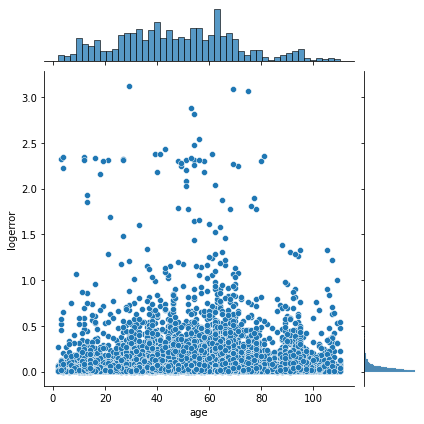

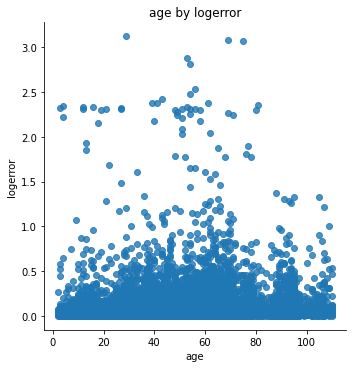

H0: There is no linear relationship between age and logerror.
HA: There is a linear relationship between age and logerror.
----------------------------------------------------------------
p-value: 1.8636961591025224e-43

With a p-value below our established alpha we reject the null hypothesis.


In [7]:
# We can demonstrate continuous feature exploration using our 'age' feature
# For positive log error
e.linear_tests(train_pos, ['age'], target)

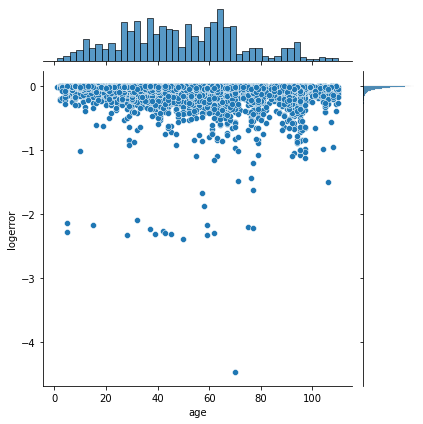

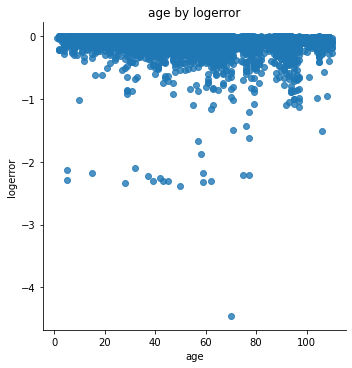

H0: There is no linear relationship between age and logerror.
HA: There is a linear relationship between age and logerror.
----------------------------------------------------------------
p-value: 7.452018292506657e-76

With a p-value below our established alpha we reject the null hypothesis.


In [8]:
# With our negative log error
e.linear_tests(train_neg, ['age'], target)

#### Question 2: Do secondary house attributes impact log error?
Our secondary house attributes were largely categorical and were explored using visualizations and a one-sample t-test. The cat_visuals() function in the explore.py module can be used for visualizations, and the explore notebook can be viewed to see the statistical analysis. 

From our exploration we visually and statistically confirm the use of has_pool and tax_delinquency, but will not be using fips or hottub_or_spa in modeling. 

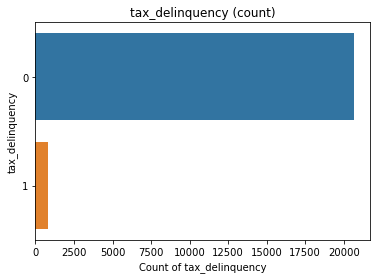

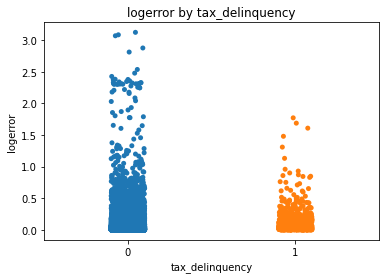

In [9]:
# We can demonstrate categorical feature exploration using our 'tax_delinquency' feature
# For positive log error
e.cat_visuals(train_pos, ['tax_delinquency'], target)

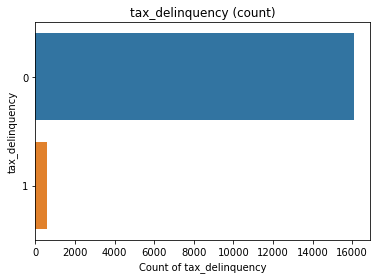

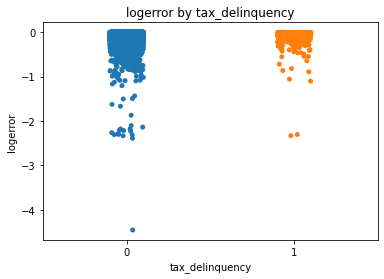

In [10]:
# For negative log error
e.cat_visuals(train_neg, ['tax_delinquency'], target)

Moving forward our exploration digs deeper into clustering work. Prior to clustering a good overview of how little correlation there is currently with our features and our target variable. The heatmap_zillow() function can provide this visual.

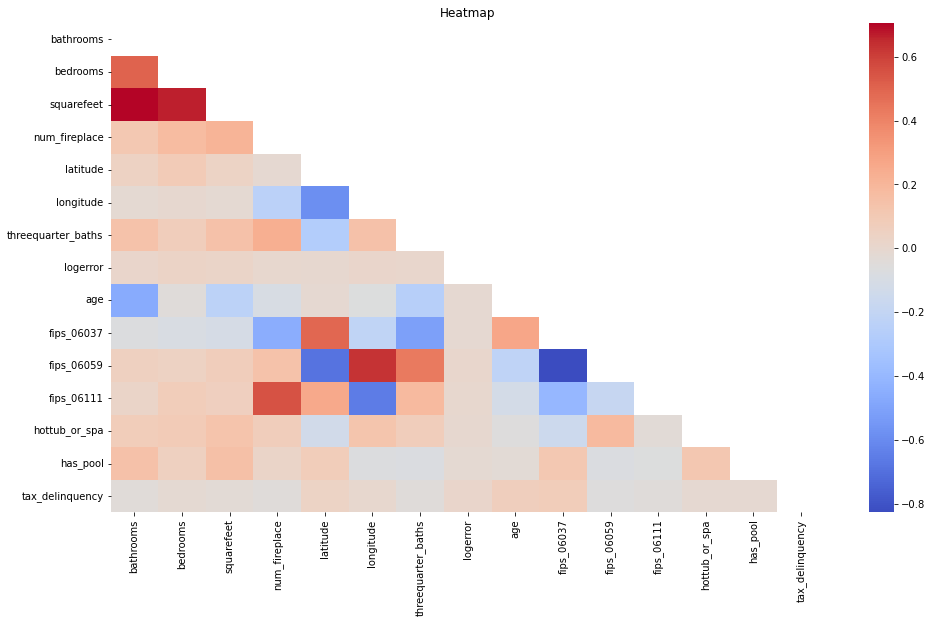

In [11]:
# Using heatmap_zillow() to see if there are any strong correlations with our target variable
e.heatmap_zillow(train)

There is a very weak correlation with age, but nothing in particular has a correlation to log error. We will still be using the features that were deemed significant through statistical tests. 

### Scaling:
Prior to clustering the data we need to scale our continuous features that will be used. To do this we will use our scale_zillow() function that resides in our explore.py module. It will take our train, validate, and test dataframes and return them with scaled features. 

In [12]:
# Selecting our features to scale
quants = ['bathrooms', 'bedrooms', 'squarefeet', 'num_fireplace', 'latitude',
          'longitude', 'threequarter_baths', 'age']

# Scaling our dataframes: train, validate, test
train, validate, test = e.scale_zillow(train, validate, test, quants)

### Clustering:
#### Question 3: Does geography impact log error?
To try to incorporate geographical data we will cluster using latitude and longitude. We will also conduct visualization and statistical testing for our regionidzip feature. 

For our clustering we will conduct an elbow test to determine the k value for number of clusters, using the elbow_test() function. We will then use the clustering_cols() function to create our clusters and apply the transformation to our train, validate, and test dataframes. Both of these functions are in the explore module.

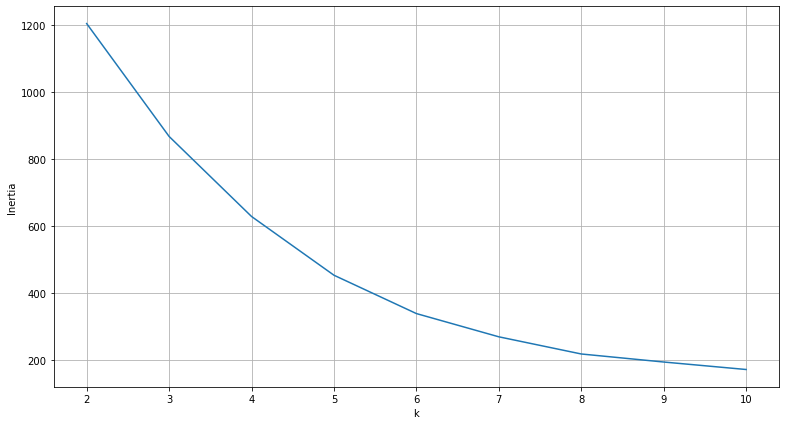

In [13]:
# Selection of features for clustering
col1 = ['latitude', 'longitude']

# Use of elbow_test() to find best k value
e.elbow_test(train, col1)

In [14]:
# Use of clustering_cols() function to find our centroids and add our cluster column to train, validate, and test
centroids, train, validate, test = e.clustering_cols(train, validate, test, col1, 6, 'lat_long_cluster')

We can map our clusters using a relplot.

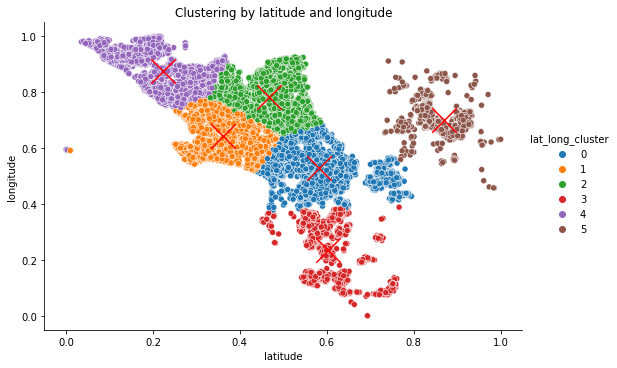

In [15]:
# Visualizing our clusters and centroids
sns.relplot(data=train, x='latitude', y='longitude', hue='lat_long_cluster', aspect=1.5)
plt.title('Clustering by latitude and longitude')
plt.scatter(centroids.latitude, centroids.longitude, marker='x', s=600, c='red')

##### Regionidzip:
Through visualizations and statistical testing (one-sample t-test) a list of statistically significant zip codes were selected to move forward with for modeling. This will be addressed in the same manner as selecting which clusters are most significant. 

#### Question 4: Can we successfully use any of our features to cluster for log error predictions? 
Using the same functions as above we analyze clusters for some of our other features.

In [16]:
# Curating our other selected features to cluster
col2 = ['bathrooms', 'bedrooms', 'squarefeet', 'age']
col3 = ['age', 'squarefeet']

In [17]:
# Calling our clustering_cols() for col2 and col3
# The elbow_test() results can be seen in the explore notebook
centroids, train, validate, test = e.clustering_cols(train, validate, test, col2, 8, 'conts_cluster')
centroids2, train, validate, test = e.clustering_cols(train, validate, test, col3, 4, 'age_sqft_cluster')

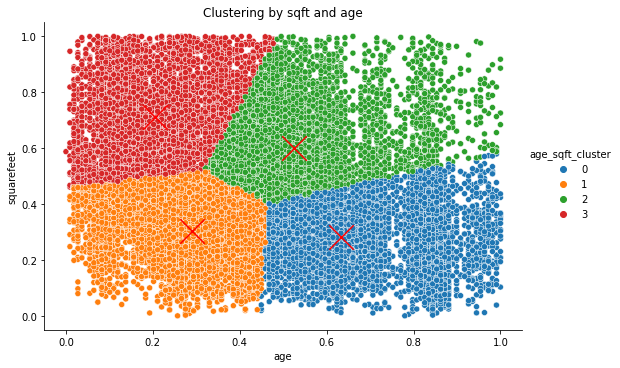

In [18]:
# A visualization of our 'age_sqft_cluster'
sns.relplot(data=train, x='age', y='squarefeet', hue='age_sqft_cluster', aspect=1.5)
plt.title('Clustering by sqft and age')
plt.scatter(centroids2.age, centroids2.squarefeet, marker='x', s=600, c='red')

#### Question 5: What can we identify about the data when log error is positive or negative? 
The log error being positive or negative was explored through visualizations with our continuous and categorical variables. There is a worthwhile pursuit to see if applying an absolute value to log error would yield better results for exploration and modeling, but that ultimately fell outside of the scope of this project and will be mentioned later in the summary.

### Statistical testing for numerous encoded columns:
Visualizations for these columns can be seen in the explore notebook. Statistical testing was done with the run_ttest_list() function to create lists of significant columns.

In [19]:
# Establishing the overall_logerror_mean for testing
overall_logerror_mean = train.logerror.mean()

# List of significant clusters for lat_long_cluster
lat_long_list = []
for i, subset in train.groupby('lat_long_cluster'):
    e.run_ttest_list(subset, lat_long_list, overall_logerror_mean, i)
    
# List of significant clusters for conts_cluster
conts_cluster = []
for i, subset in train.groupby('conts_cluster'):
    e.run_ttest_list(subset, conts_cluster, overall_logerror_mean, i)
    
# List of significant clusters for age_sqft_cluster
age_sqft = []
for i, subset in train.groupby('age_sqft_cluster'):
    e.run_ttest_list(subset, age_sqft, overall_logerror_mean, i)
    
# List of significant zip codes for regionidzip
zip_list = []
for i, subset in train.groupby('regionidzip'):
    e.run_ttest_list(subset, zip_list, overall_logerror_mean, i)

### Additional encoding:
Our new cluster columns and regionidzip need to be encoded to represent the significant values.

In [20]:
# Selection of our columns and encoding applied to train, validate, and test dataframes
to_encode = ['conts_cluster', 'regionidzip', 'lat_long_cluster', 'age_sqft_cluster']
for col in to_encode:
    train = pd.get_dummies(train, columns=[col])
    validate = pd.get_dummies(validate, columns=[col])
    test = pd.get_dummies(test, columns=[col])

### Trimming our dataframes:
Before we move forward to modeling we will trim whatever features will not be used. The selection of these was determined through our visual and statistical exploration. 

In [21]:
# Columns that are redundant through new columns or were not deemed significant that can be dropped
to_drop = ['latitude', 'longitude', 'fips_06059', 'fips_06111', 'fips_06037', 'hottub_or_spa']

# Dropping them from our dataframes
train = train.drop(columns=to_drop)
validate = validate.drop(columns=to_drop)
test = test.drop(columns=to_drop)

Trimming our encoded cluster columns will utilize the lists that were created previously. The function cluster_trim() will loop through the train, validate, and test dataframes and remove the columns that were not deemed statistically significant.

In [22]:
# Removing the unnecessary lat_long_cluster encoded columns
train, validate, test = e.cluster_trim(lat_long_list, 'lat_long_cluster', train, validate, test)

In [23]:
# Removing the unnecessary conts_cluster encoded columns
train, validate, test = e.cluster_trim(conts_cluster, 'conts_cluster', train, validate, test)

In [24]:
# Removing the unnecessary age_sqft_cluster encoded columns
train, validate, test = e.cluster_trim(age_sqft, 'age_sqft', train, validate, test)

In [25]:
# Removing the unnecessary age_sqft_cluster encoded columns
train, validate, test = e.cluster_trim(zip_list, 'regionidzip', train, validate, test)

### Exploration Summary:
Through a number of visualizations, clustering, and statistical tests our selected features are:
- bathrooms
- bedrooms
- squarefeet
- num_fireplace
- threequarter_baths
- logerror (target)
- age
- has_pool 
- tax_delinquency
- lat_long_cluster (cluster based on latitude and longitude)
- conts_cluster (cluster based on bathrooms, bedrooms, squarefeet, and age)
- age_sqft_cluster (cluster based on age and squarefeet)
- regionidzip (39 unique encoded zip codes)

Categorical features that were eliminated primarily through statistical testing:
- fips
- hottub_or_spa
- Various encoded cluster and regionidzip columns

Continuous features that were eliminated through engineering with clustering:
- latitude
- longitude

In regards to the questions we asked of the data throughout the planning and exploration phases the big takeaways are:
- The data we do have is not likely to be significantly useful, modeling will tell us more about this
    - While the majority of our features are worth bringing forward to modeling none of them seemingly have a strong impcat on log error
- Log error has similarities and differences in key drivers compared to the tax value/home price it originates from 
- Clustering allows for more nuanced approach to geography that would otherwise be difficult to bring to modeling

### Modeling:

In [26]:
# Using our x_y_splits() function, taking in train, validate, test and returning the x and y components
x_train, y_train, x_validate, y_validate, x_test, y_test = m.x_y_splits(train, validate, test)

In [27]:
# Making our y_train, y_validate, y_test dataframes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [28]:
# Using baseline_selection() function to provide our best baseline to use
baseline_RMSE = m.baseline_selection(y_train, y_validate)

Mean log error provides a better baseline. Returning mean RMSE of 0.157635.


In [29]:
# Using ols_model() function to show OLS results, takes our x and y components
m.ols_model(x_train, y_train, x_validate, y_validate)

RMSE for OLS using LinearRegression
Training:  0.154243 
Validation:  0.160229


In [30]:
# Using LassoLars_model() function to show Lasso + Lars results, takes our x and y components
m.LassoLars_model(x_train, y_train, x_validate, y_validate)

RMSE for Lasso + Lars
Training:  0.154894 
Validation:  0.160376


In [31]:
m.Poly_reg_model(x_train, y_train, x_validate, y_validate, 2)

(16368, 54)
(16368, 54)
RMSE for Polynomial Model, with two degrees
Training:  0.153445 
Validation:  1601650415216.051


In [32]:
#m.Poly_reg_model(x_train, y_train, x_validate, y_validate, 3)

In [33]:
# Using Tweedie_model() function to show TweedieRegressor results, using all three of our x and y components
# This is the only model that test components are used with and is our final result for performance
m.Tweedie_model(x_train, y_train, x_validate, y_validate, x_test, y_test)

RMSE using Tweedie, power=1 & alpha=0
Training:  0.154264 
Validation:  0.160283 
Test:  0.165173


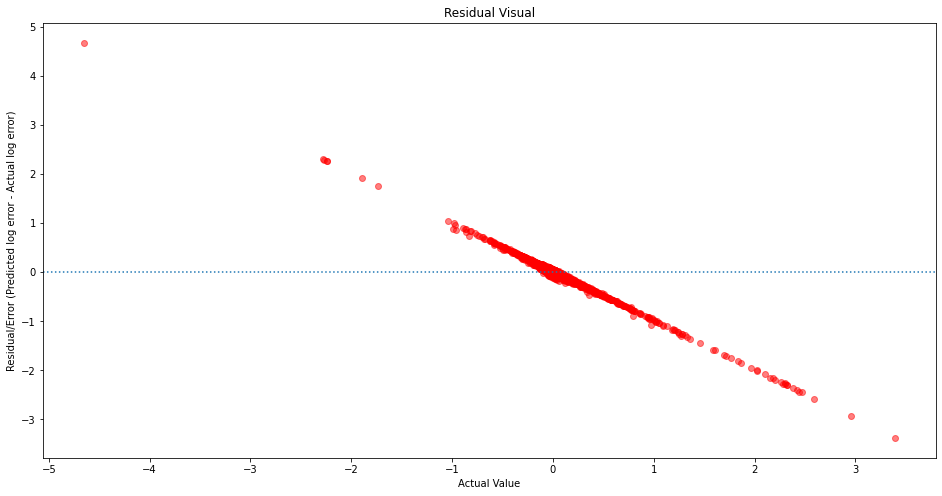

In [34]:
# Using our residual_visual() function and our test target variable to map our residual outcomes
m.residual_visual(y_test)